In [1]:
from embedders import SwivelEmbedder, BertEmbedder
from elastic_setup.elastic import Elastic
import pandas as pd
import numpy as np

## Loading data
In this repo, I used 1k out of 50k documents of the [TREC-COVID](https://www.kaggle.com/c/trec-covid-information-retrieval/data) dataset, which consists of articles about the COVID-19.

Huge credit to my friend [@NgTatu](https://github.com/NgTatu) who extracted the text from json.

In [2]:
data = pd.read_csv("data/data.csv")
print(data)

     cord_uid                                               text
0    ug7v899j  Objective: This retrospective chart review des...
1    02tnwd4m  Inflammatory diseases of the respiratory tract...
2    ejv2xln0  Surfactant protein-D (SP-D) participates in th...
3    2b73a28n  ARDS = acute respiratory distress syndrome; BA...
4    9785vg6d  commentary review reports primary research CCR...
..        ...                                                ...
995  md293k0m  Objectives. To assess the beneficial and adver...
996  91lzomwp  Background: Hospitals are often the epicentres...
997  4owe9lf5  Alloimmune lung syndromes after allogeneic SCT...
998  9gozwdng  The prediction of antibody-protein (antigen) i...
999  5rm1za8z  Background: Despite the launch of the national...

[1000 rows x 2 columns]


## Create elastic index

Of course, first we need to [download and install elasticsearch](https://www.elastic.co/downloads/elasticsearch) to enable a local elastic server on `localhost:9200`

Source code of the `Elastic` class is in `elastic_setup/elastic.py`

To create an idex (basically a table in a database), we need to config it. Here is the content of my configuration file `elastic_setup/index_config.json`:

```
{
"settings" : {
    "number_of_shards": 1,
    "number_of_replicas": 1
},

"mappings": {
        "properties": {
            "cord_uid": {"type": "text"},
            "swivel_embedding": {"type":  "dense_vector", "dims":  128},
            "bert_embedding": {"type": "dense_vector", "dims":  128}
        }}
}
```

The important things here are the `properties`, which consist of `field_name` and `data_type`.

In this example, I will store the `cord_uid` (datatype: text) from the `data['cord_uid']` above, embeded the `data['text']` by two embedders (swivel and bert) then store their respective embeddings into the index.
Elasticsearch supports the `dense_vector` datatype for storing array of floats. Here I used Swivel and BERT embedders with hidden size `128`.

In [4]:
elastic = Elastic()
elastic.create_index(name="trec-covid", config_file="elastic_setup/index_config.json")

[INFO] index trec-covid has been created!


## Create embeddings of the data

Here I load two embedders from TensorFlow Hub, with two ways to embed text:
- Swivel: can embed text directly
- BERT: need a preprocessor to pack input for it

I implemented the two embedders in `embedders.py`, check it out!

In [5]:
swivel = SwivelEmbedder()

Loaded pre-trained model https://tfhub.dev/tensorflow/cord-19/swivel-128d/3 successfully!


In [8]:
bert = BertEmbedder()

Loaded pre-trained model https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1 successfully!


**Just ignore the exception and warnings**, the model has been loaded successfully

In [10]:
# Create embedding for every 'text' rows in the data
data['swivel_embedding'] = data['text'].apply(lambda t: swivel.embed_single_text(t)[0].tolist())

In [11]:
data['bert_embedding'] = data['text'].apply(lambda t: bert.embed_single_text(t)[0].tolist())

Let see how the data looks like

In [12]:
print(data)

     cord_uid                                               text  \
0    ug7v899j  Objective: This retrospective chart review des...   
1    02tnwd4m  Inflammatory diseases of the respiratory tract...   
2    ejv2xln0  Surfactant protein-D (SP-D) participates in th...   
3    2b73a28n  ARDS = acute respiratory distress syndrome; BA...   
4    9785vg6d  commentary review reports primary research CCR...   
..        ...                                                ...   
995  md293k0m  Objectives. To assess the beneficial and adver...   
996  91lzomwp  Background: Hospitals are often the epicentres...   
997  4owe9lf5  Alloimmune lung syndromes after allogeneic SCT...   
998  9gozwdng  The prediction of antibody-protein (antigen) i...   
999  5rm1za8z  Background: Despite the launch of the national...   

                                      swivel_embedding  \
0    [1.553953219841373, -3.586346474155793, -0.879...   
1    [5.046501894520454, -3.3189891947270085, 0.785...   
2    [-0.

## Index (save) the embeddings into our local elastic server.

First, config the data into appropriate format

In [13]:
data['_op_type'] = "index"
data['_index'] = "trec-covid"
data = data[['_op_type', '_index', 'cord_uid', 'swivel_embedding', 'bert_embedding']]
index_data = data.to_dict(orient='records')
print(len(index_data))
print(index_data[0])

1000
{'_op_type': 'index', '_index': 'trec-covid', 'cord_uid': 'ug7v899j', 'swivel_embedding': [1.553953219841373, -3.586346474155793, -0.8799602454139178, -0.17417714949896895, -0.6112234713518474, -0.6828935100927336, 1.488666478938926, -0.31479096400722695, -1.138237584974247, -0.047896688088639346, -0.18212782378464923, 1.5360481886889228, 0.38479430287417926, -0.1993231333250631, -2.7913036548429875, -0.6207273788195986, -0.7879073491465388, 1.163044451368958, -0.12473317286129576, 5.327564277437984, -0.7924496823038389, -8.742434740940315, 0.14709633191562566, 0.270575914065141, 0.43489962788181485, 1.5682406471109234, -1.1991709120686183, 0.5556905728547276, -0.7943615564651078, -0.6345256311779394, -6.626017099325676, -3.3888321570990816, 6.6156971480088425, -0.3330869358337006, -1.1943553991454665, -0.16287365174394747, 0.046487444590265936, -1.0020558776821578, 4.614595934016548, 0.029303235042825098, -0.14882555878230022, -1.5758010704834349, 1.906682567516973, 0.39821902849

After we're done, index the data!

In [15]:
elastic.index_documents(index_data)

**Type the url below and see the result:** our embeddings has been stored!
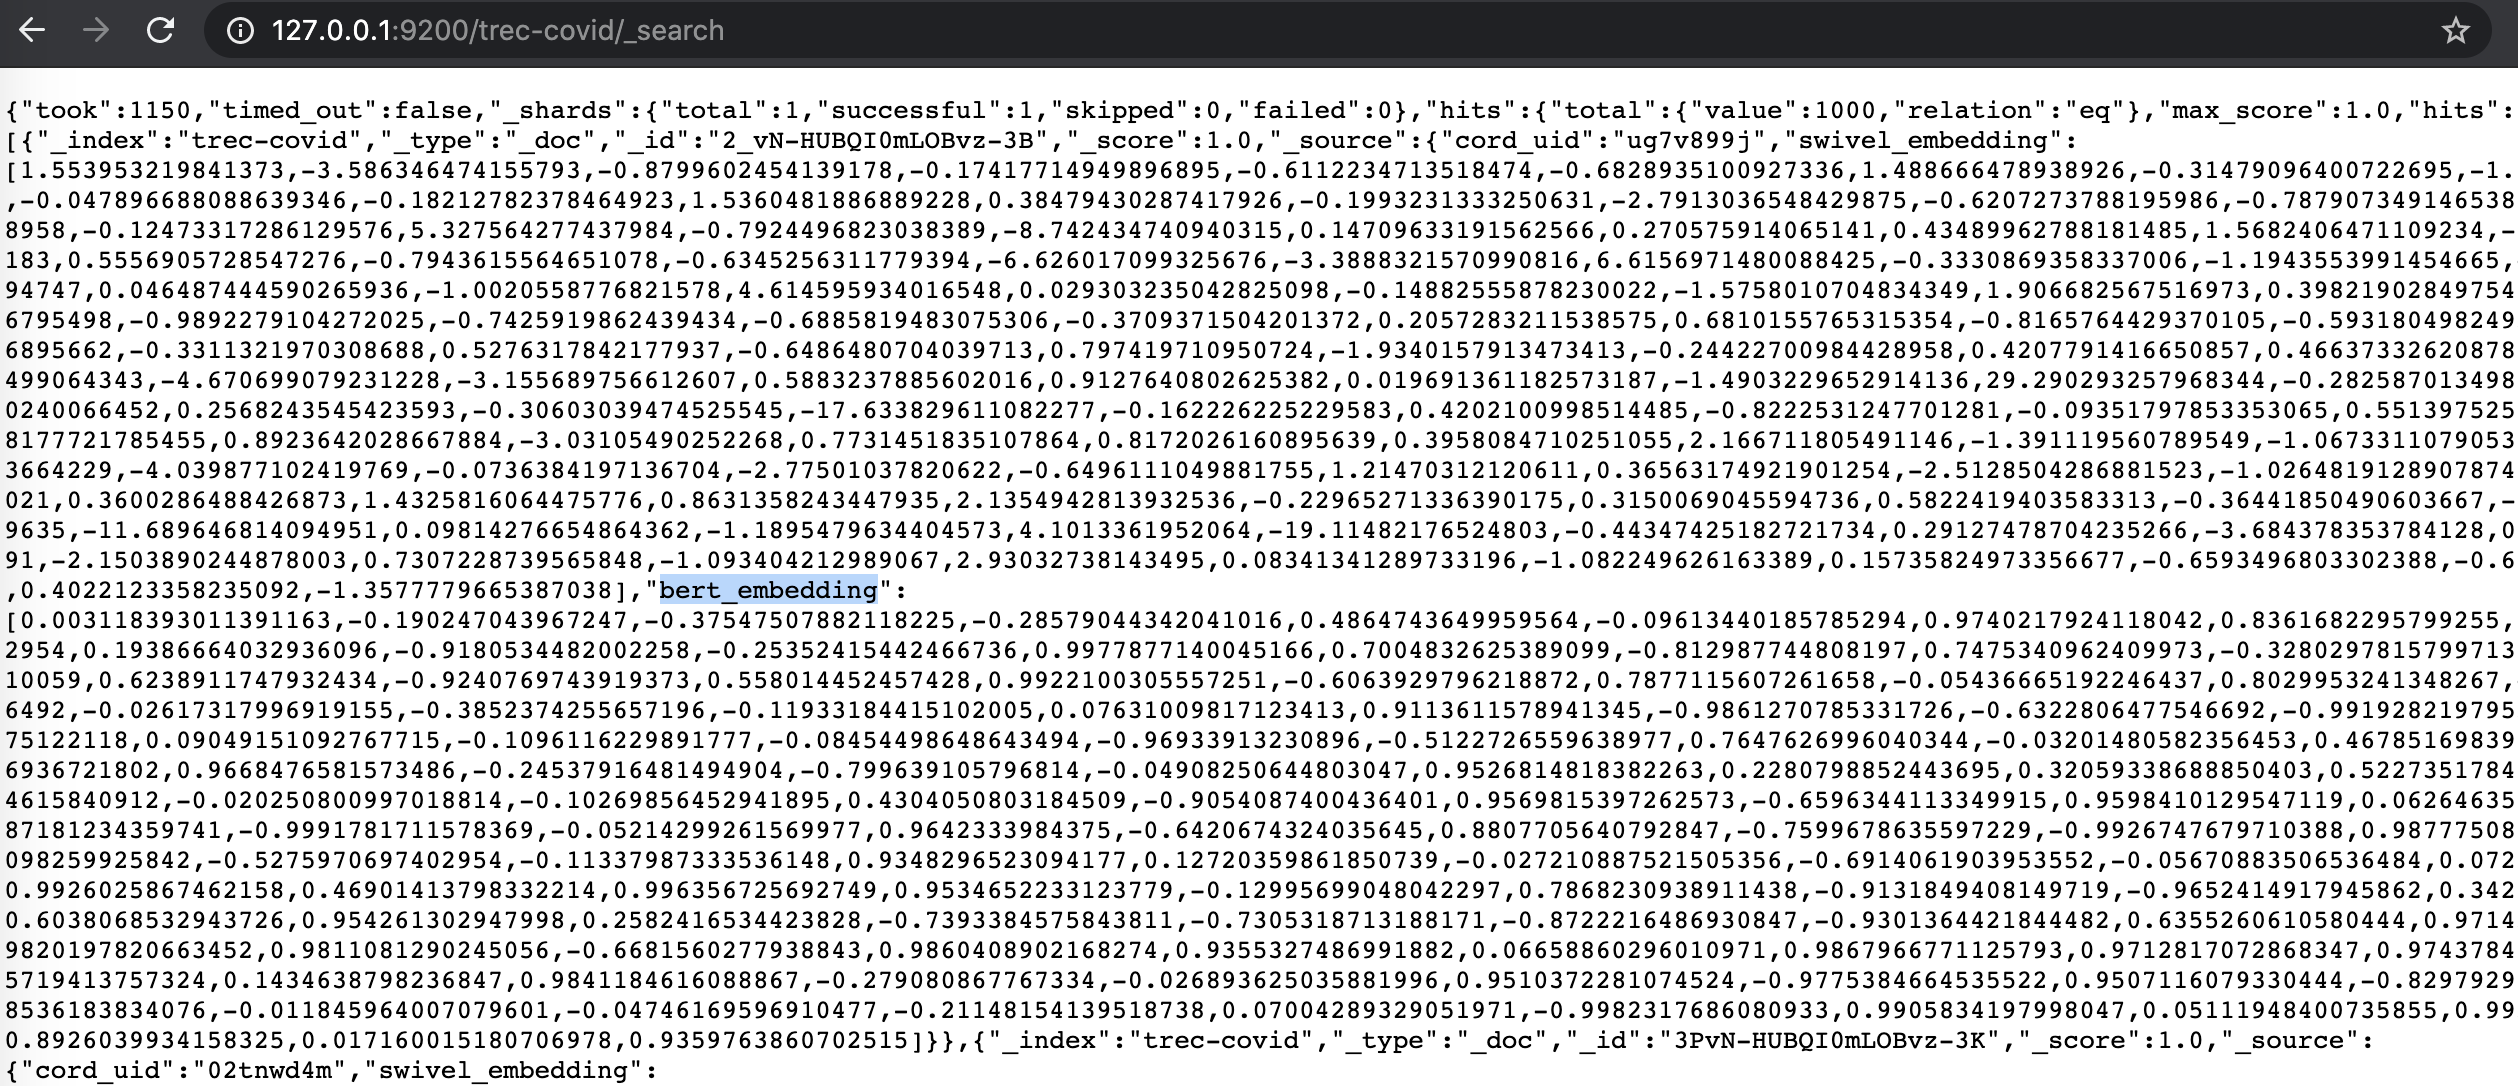

## Retrieve information

In [18]:
def retrieve(query:str, n_returns:int, index_name: str, embedder='swivel'):
    '''
    return: 2-D list [['cord_uid': cosine_similarity]], sorted by cosine score descendingly
    e.g.[['4lsz69h6', 0.963506],
         ['wcwkcffz', 0.9492332000000001],
         ['omq7z0ei', 0.9438302999999999]]
    '''
    if embedder == 'swivel':
        query_vector = swivel.embed_single_text(query)[0].tolist()
    elif embedder == 'bert':
        query_vector = bert.embed_single_text(query)[0].tolist()
    else:
        raise ValueError("embedder must be either 'swivel' or 'bert'!")
        
    script_query = {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": f"cosineSimilarity(params.query_vector, '{embedder}_embedding') + 1.0", # Add 1.0 because ES doesnt support negative score
                "params": {"query_vector": query_vector}
            }
        }
    }
    
    response = elastic.search(index_name, script_query, n_returns, list_fields_to_return=["cord_uid"])
    
    res = []
    for hit in response["hits"]["hits"]:
        res.append([hit["_source"]["cord_uid"], hit["_score"] - 1])
    return np.array(res)

In [19]:
query = "COVID-19 treatment"

print("10 best matching documents of the query:")
print(retrieve(query=query, n_returns=10, index_name="trec-covid", embedder='swivel'))

10 best matching documents of the query:
[['fec4kt20' '0.6429787']
 ['au1nf394' '0.6306145000000001']
 ['ng4rrdte' '0.6300861']
 ['unotv53r' '0.6287388']
 ['k0p166fr' '0.6205877']
 ['54f3q2o5' '0.6191529']
 ['mgj9zfft' '0.6152158000000001']
 ['rxn5lges' '0.6083254']
 ['00rk8fb5' '0.6025339000000001']
 ['kuf3ssdb' '0.6022240999999999']]
